In [2]:
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from tools.vis_tool import *
from tools.transform import cornerpoint_projection
from tools.map import single_scenemap
from tools.astar import astar
import random
import math

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [10]:
gridSize=0.01

controller = Controller(
    agentMode="locobot",
    visibilityDistance=1.5,
    scene="FloorPlan_Train1_3",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

In [13]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)


<ai2thor.server.Event at 0x7fa2daad2f10
    .metadata["lastAction"] = Initialize
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}
>

In [14]:
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=2.5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=3.25,
    skyboxColor="white"
)
pass

In [15]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']


In [16]:
controller.step(
    action="Teleport",
    position = rstate[20]
)
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0.7000000000000001 10.4 -5.300000000000001 0.5
(98, 59)


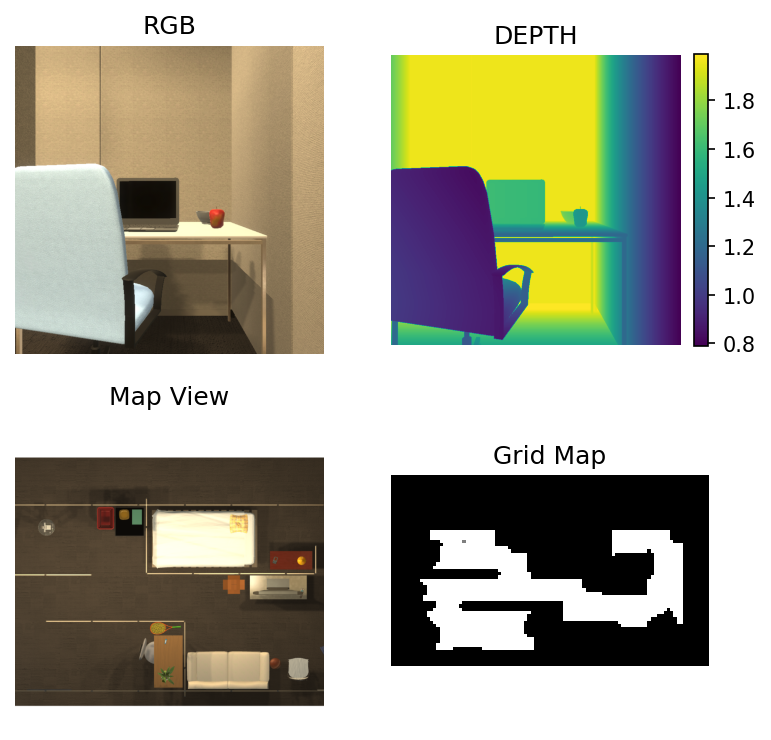

In [17]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

## Notice stepsize should be smaller than gridsize
stepsize = 0.1
sm = single_scenemap(scene_bounds,rstate,stepsize)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)


## Custom Astar

In [18]:
initstate = 20
goalstate = 100000


pos = rstate[initstate]
pos = [pos['x'],pos['z']]

goal = rstate[goalstate]
goal = [goal['x'],goal['z']]

pos,goal

([2.9800000190734863, -1.4700000286102295],
 [4.639999866485596, -4.239999771118164])

In [20]:
cpos= sm.gridmap_pos(pos)
cgoal = sm.gridmap_pos(goal)
print(cpos,cgoal)
path = astar(sm.grid_map,cgoal,cpos)

[22, 38] [39, 10]


KeyboardInterrupt: 

In [21]:
def show_path(path,gridmap):
    gridmap_rgb = np.expand_dims(gridmap,-1)
    gridmap_rgb = np.repeat(gridmap_rgb,3,-1)
    for p in path[1:-1]:
        gridmap_rgb[p[0],p[1],:] = [1,0,0]
    init = path[0]
    end = path[-1]
    gridmap_rgb[init[0],init[1],:] = [0,1,0]
    gridmap_rgb[end[0],end[1],:] = [0,1,1]
    gridmap_rgb = np.rot90(gridmap_rgb)
    plt.axis('off')
    plt.imshow(gridmap_rgb)

show_path(path,sm.grid_map)
e=0

NameError: name 'path' is not defined

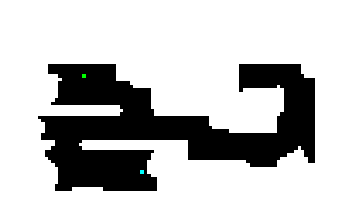

In [22]:
## When astar doesn't work

gridmap = sm.grid_map
init = cpos
end = cgoal

gridmap_rgb = np.expand_dims(gridmap,-1)
gridmap_rgb = np.repeat(gridmap_rgb,3,-1)

gridmap_rgb[init[0],init[1],:] = [0,1,0]
gridmap_rgb[end[0],end[1],:] = [0,1,1]
gridmap_rgb = np.rot90(gridmap_rgb)
plt.axis('off')
plt.imshow(gridmap_rgb)

In [25]:
xyzpath = []
for e in path:
    pos = sm.gridmap2xyz(e,rstate[goalstate]['y'])
    xyzpath.append(pos)

xyzpath.insert(0,rstate[initstate])
xyzpath.append(rstate[goalstate])


NameError: name 'path' is not defined

In [26]:
controller.step(
    action="Teleport",
    position = rstate[initstate]
)

<ai2thor.server.Event at 0x7fa2da3ba820
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [38]:
# Teleport to initial position
import time

controller.step(
    action="Teleport",
    position = rstate[initstate]
)

for e in range(len(xyzpath)-1):

    dx = xyzpath[e+1]['x'] - xyzpath[e]['x']
    dz = xyzpath[e+1]['z'] - xyzpath[e]['z']
    trot = math.atan2(dx,dz)*180/math.pi
    crot = controller.last_event.metadata['agent']['rotation']['y'] 
    rot = trot - crot
    event = controller.step(
        action="RotateRight",
        degrees=rot
    )
    

    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        break
    
    event = controller.step(
        action="MoveAhead",
        moveMagnitude=math.sqrt(dx**2+dz**2)
    )

    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        break
    
    time.sleep(0.5)
    
controller.step(
    action="Teleport",
    position = controller.last_event.metadata['agent']['position']
)

Collision!


<ai2thor.server.Event at 0x7ff369ee2310
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

[2.9800000190734863, -1.4700000286102295]


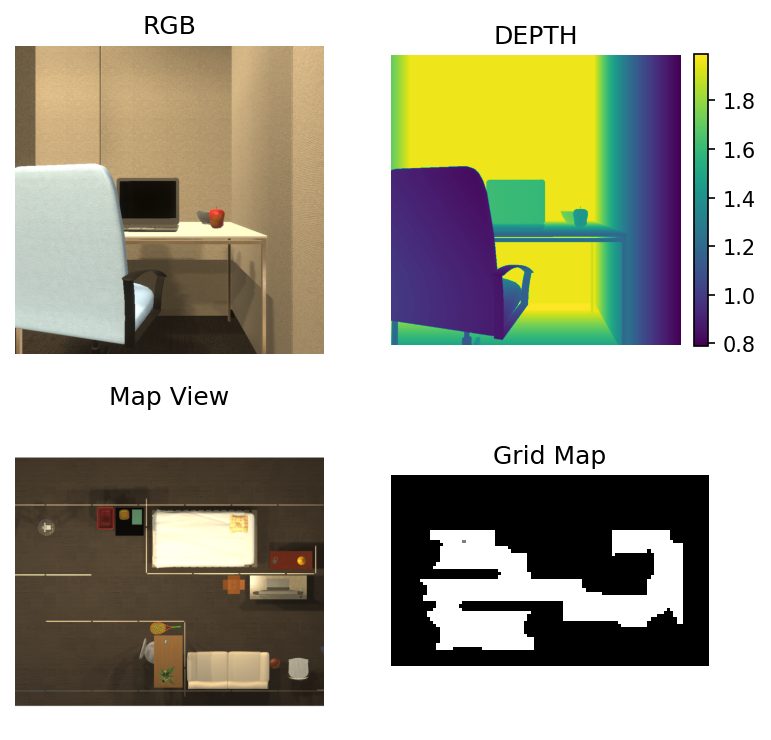

In [27]:
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
print(pos)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

## Built-in path planning

In [28]:
def rstate2pos(rstate):
    ls = []
    ls.append(rstate['x'])
    ls.append(rstate['z'])
    
    return ls

[[22, 38], [32, 30], [34, 28], [34, 27], [32, 26], [22, 20], [20, 19], [20, 17], [22, 16], [39, 10]]


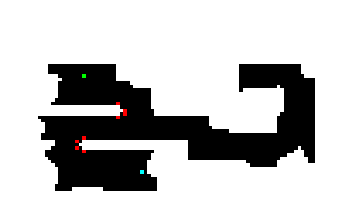

In [29]:
initstate = 20
goalstate = 100000

from ai2thor.util.metrics import (
    get_shortest_path_to_point
)
incpos = rstate[initstate]
ingoal = rstate[goalstate]

inpath = get_shortest_path_to_point(
   controller=controller,
    target_position= ingoal,
    initial_position= incpos,
    allowed_error=0
)

# Adjust invalid depth -> Don't know why this happens
for point in inpath:
    point['y'] = incpos['y']


savepath = []
for point in inpath:
    xzpoint = [point['x'], point['z']]
    temp = sm.gridmap_pos(xzpoint)
    savepath.append(temp)

print(savepath)
show_path(savepath,sm.grid_map)

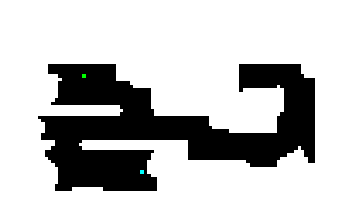

In [30]:
## When built-in doesn't work

gridmap = sm.grid_map
init = sm.gridmap_pos(rstate2pos(incpos))
end = sm.gridmap_pos(rstate2pos(inpath[-1]))

gridmap_rgb = np.expand_dims(gridmap,-1)
gridmap_rgb = np.repeat(gridmap_rgb,3,-1)

gridmap_rgb[init[0],init[1],:] = [0,1,0]
gridmap_rgb[end[0],end[1],:] = [0,1,1]
gridmap_rgb = np.rot90(gridmap_rgb)
plt.axis('off')
plt.imshow(gridmap_rgb)

In [31]:
controller.step(dict(action='GetReachablePositions'))

temp = controller.last_event.metadata['actionReturn']


In [74]:
import time

controller.step(
    action="Teleport",
    position = rstate[initstate],
    rotation=dict(x=0, y=40, z=0),
)

for e in range(len(inpath)-1):

    dx = inpath[e+1]['x'] - inpath[e]['x']
    dz = inpath[e+1]['z'] - inpath[e]['z']
    trot = math.atan2(dx,dz)*180/math.pi
    crot = controller.last_event.metadata['agent']['rotation']['y'] 
    rot = trot - crot
    event = controller.step(
        action="RotateRight",
        degrees=rot
    )
    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        # break
    
    
    event = controller.step(
        action="MoveAhead",
        moveMagnitude=math.sqrt(dx**2+dz**2)
    )
    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        # break
    
    time.sleep(0.5)

controller.step(
    action="Teleport",
    position = controller.last_event.metadata['agent']['position']
)


Collision!
Collision!
Collision!
Collision!
Collision!
Collision!
Collision!
Collision!


<ai2thor.server.Event at 0x7fa2da2512e0
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

Current position: {'x': 2.9000000953674316, 'y': 0.9009997248649597, 'z': -1.899999976158142} Goal position {'x': 2.799999952316284, 'y': 0.9009997248649597, 'z': -1.5}


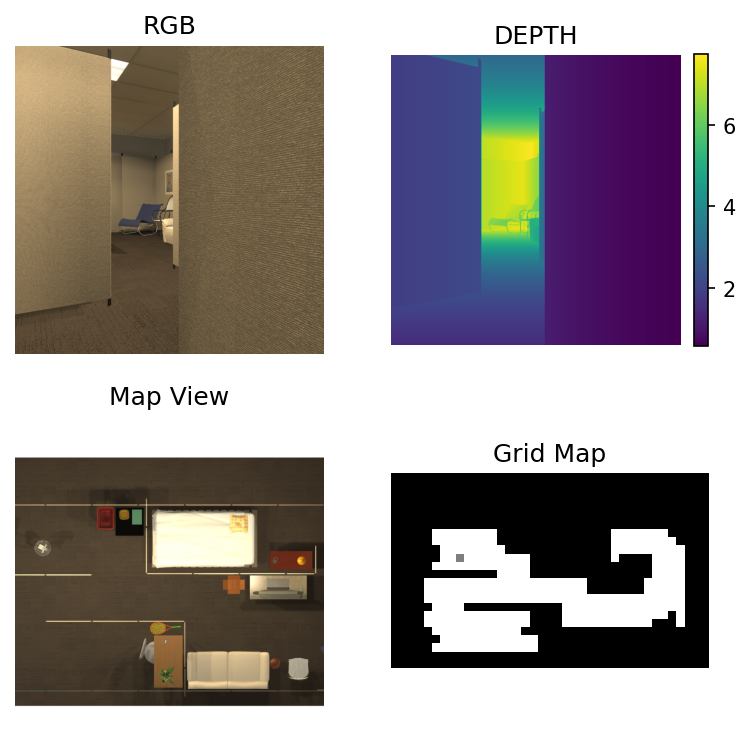

In [85]:
pos = controller.last_event.metadata['agent']['position']
print("Current position:",pos, "Goal position", rstate[goalstate])
pos = [pos['x'],pos['z']]
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)